In [1]:
import torch
import random
import numpy as np

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
import torchvision.datasets

In [4]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [6]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [7]:
X_train = X_train.float()
X_test = X_test.float()

In [8]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [9]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

In [10]:
import matplotlib.pyplot as plt

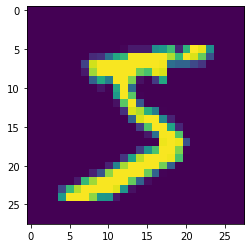

tensor(5)


In [11]:
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [12]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [13]:
class MNISTNet(torch.nn.Module):
  def __init__(self, n_hidden_neurons):
    super(MNISTNet, self).__init__()
    self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
    self.ac1 = torch.nn.Sigmoid()
    self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)

  def forward(self, x):
    x = self.fc1(x)
    x = self.ac1(x)
    x = self.fc2(x)
    return x

In [14]:
mnist_net = MNISTNet(100)

In [15]:
torch.cuda.is_available()

True

In [16]:
!nvidia-smi

Tue Oct 26 12:24:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    30W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
device

device(type='cuda', index=0)

In [19]:
mnist_net = mnist_net.to(device)

In [20]:
# list(mnist_net.parameters())

In [21]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [22]:
batch_size = 100

In [23]:
test_accuracy_history = []
test_loss_history = []

In [24]:
X_test = X_test.to(device)
y_test = y_test.to(device)

In [25]:
for epoch in range(10000):
  order = np.random.permutation(len(X_train))

  for start_index in range(0, len(X_train), batch_size):
    optimizer.zero_grad()

    batch_indexes = order[start_index : start_index + batch_size]

    X_batch = X_train[batch_indexes].to(device)
    y_batch = y_train[batch_indexes].to(device)

    preds = mnist_net.forward(X_batch)

    loss_value = loss(preds, y_batch)
    loss_value.backward()

    optimizer.step()

  test_preds = mnist_net.forward(X_test)
  test_loss_history.append(loss(test_preds, y_test))

  accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
  test_accuracy_history.append(accuracy)
  print(accuracy)

tensor(0.9112, device='cuda:0')
tensor(0.9115, device='cuda:0')
tensor(0.9210, device='cuda:0')
tensor(0.9202, device='cuda:0')
tensor(0.9288, device='cuda:0')
tensor(0.9231, device='cuda:0')
tensor(0.9274, device='cuda:0')
tensor(0.9287, device='cuda:0')
tensor(0.9312, device='cuda:0')
tensor(0.9294, device='cuda:0')
tensor(0.9325, device='cuda:0')
tensor(0.9328, device='cuda:0')
tensor(0.9313, device='cuda:0')
tensor(0.9297, device='cuda:0')
tensor(0.9357, device='cuda:0')
tensor(0.9381, device='cuda:0')
tensor(0.9399, device='cuda:0')
tensor(0.9399, device='cuda:0')
tensor(0.9406, device='cuda:0')
tensor(0.9406, device='cuda:0')
tensor(0.9417, device='cuda:0')
tensor(0.9409, device='cuda:0')
tensor(0.9414, device='cuda:0')
tensor(0.9445, device='cuda:0')
tensor(0.9441, device='cuda:0')
tensor(0.9433, device='cuda:0')
tensor(0.9418, device='cuda:0')
tensor(0.9471, device='cuda:0')
tensor(0.9456, device='cuda:0')
tensor(0.9462, device='cuda:0')
tensor(0.9471, device='cuda:0')
tensor(0

KeyboardInterrupt: ignored

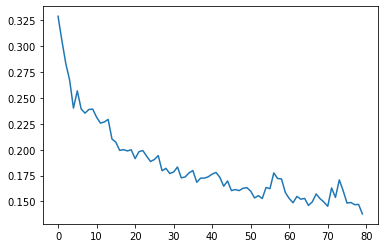

In [29]:
# plt.plot(test_accuracy_history)
plt.plot(test_loss_history);